<a href="https://colab.research.google.com/github/DVerma11/Reddit_Anxiety_Symptoms_Narratives_NLP_Exploration/blob/main/Section_4_Sentiment_Analysis_Symptoms_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Section 4: Sentiment Analysis using 2 methods- Vader and CardiffNLP RoBERTa Sentiment


Sentiment analysis was applied on "comment_body_clean" after preprocessing to characterize the emotional profile associated with each symptom and coping, using 3 methods to improve robustness and interpretability of symptoms and coping skills.
This will help us extract most and least distressing symptoms from patient narratives. For coping skills, it will help us determine most positive coping strategies.

Each method captures different psychological signals and complementary.

**Role of Each Sentiment Model:**

1️⃣ VADER – Lexicon-Based Polarity

Best at: Explicit emotional language and Social media tone (caps, intensifiers, negations)

Example: “I’m terrified and exhausted” --> Strong negative polarity

Strengths: Fast, Transparent, Interpretable

Limitations: Misses clinical nuance, No emotion categories

2️⃣ CardiffNLP (RoBERTa Twitter Sentiment) – Contextual Polarity

Best at: Implicit emotional tone, Modern social media phrasing

Example: “Another night of no sleep, great.”--> Correctly detects negative sentiment (sarcasm)

Strengths: Better context understanding than VADER, Robust to informal text

Limitations: Still coarse: POS / NEU / NEG, No emotion specificity


Two Models Together Are Stronger: in providing Polarity (VADER + Cardiff) and  Context robustness (Cardiff).



## 4.0 Load file

In [ ]:
#load file into new DataFrames
import pandas as pd

In [ ]:
symptom_phrases_exploded_df = pd.read_csv("Step2B_symptom_phrases_exploded.csv")

In [ ]:
symptom_phrases_exploded_df["comment_body_clean"].head(2)

,comment_body_clean
0,omg you have no idea how much better i feel. i...
1,omg you have no idea how much better i feel. i...


## 4.1 Vader Sentiment Analysis

VADER is a lexicon- and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. The predicted sentiment (ie, compound score) is computed by summing the valence scores of each word in the lexicon, adjusted according to emotion-related rules, and then normalized to have values between −1 (most extreme negative emotion) and +1 (most extreme positive emotion).

In [ ]:
# ============================================
# 0️⃣ Imports
# ============================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Create comment-level table (one row per comment)
symptom_text_df = (
    symptom_phrases_exploded_df[["comment_id", "comment_body_clean"]]
    .drop_duplicates()
    .reset_index(drop=True)
)


In [ ]:
# VADER Sentiment Analysis

sia = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    score = sia.polarity_scores(text)["compound"]
    if score > 0.05:
        label = "positive"
    elif score < -0.05:
        label = "negative"
    else:
        label = "neutral"
    return score, label

# Apply VADER to symptom comments
vader_results = symptom_text_df["comment_body_clean"].apply(get_vader_sentiment)
symptom_text_df["vader_compound"] = vader_results.apply(lambda x: x[0])
symptom_text_df["vader_label"] = vader_results.apply(lambda x: x[1])


# Merge back to exploded dataframes
symptom_phrases_exploded_df = symptom_phrases_exploded_df.merge(
    symptom_text_df[["comment_id", "vader_compound", "vader_label"]],
    on="comment_id",
    how="left"
)


In [ ]:
# Save the exploded symptom phrases dataframe with VADER sentiment
output_file = "Step4A_symptom_comments_with_vader.csv"
symptom_phrases_exploded_df.to_csv(output_file, index=False)
print(f"✅ Saved VADER sentiment results to {output_file}")


✅ Saved VADER sentiment results to Step4A_symptom_comments_with_vader.csv


In [ ]:
symptom_text_df[
    ["comment_id", "comment_body_clean", "vader_compound", "vader_label"]
].head(10)


,comment_id,comment_body_clean,vader_compound,vader_label
0,l5k13qf,omg you have no idea how much better i feel. i...,0.2732,positive
1,l5k4qae,thanks for this. i experience a ton of similar...,0.4837,positive
2,l5l1d2d,though feeling all of these symptoms is incred...,0.8668,positive
3,l5kjm8b,wow this was so reassuring to me. i was just t...,0.5082,positive
4,lwwknq7,hello everyone. i m currently recovering from ...,-0.9569,negative
5,l5kq0sj,so many of these symptoms i didn t realize had...,-0.9469,negative
6,l5lcw8u,thanks for this i have severe health anxiety c...,-0.5994,negative
7,l5leb2f,thanks very much for this. i always suffered a...,0.7452,positive
8,l5lmehb,thank you for this comprehensive list of your ...,-0.4840,negative
9,lnj6vzo,i have most of these. i can not believe that y...,0.0000,neutral


## 4.2 CardiffNLP RoBERTa Sentiment (POS/NEG/NEU)

Using confidence score instead of compound score for CardiffNLP RoBERTa

In [ ]:
#faster for next time
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model.eval()

def get_cardiff_batch(text_list, batch_size=32):
    results = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        inputs = tokenizer(batch, truncation=True, padding=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
            scores = torch.softmax(outputs.logits, dim=1).cpu().numpy()
        for score in scores:
            labels = ["NEG", "NEU", "POS"]
            top_label = labels[score.argmax()]
            results.append((score.max(), top_label))
    return results

results = get_cardiff_batch(symptom_text_df["comment_body_clean"].tolist(), batch_size=32)
symptom_text_df["cardiff_confidence"] = [r[0] for r in results]
symptom_text_df["cardiff_label"] = [r[1] for r in results]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

In [ ]:
symptom_text_df.head()


,comment_id,comment_body_clean,vader_compound,vader_label,cardiff_confidence,cardiff_label
0,l5k13qf,omg you have no idea how much better i feel. i...,0.2732,positive,0.753039,POS
1,l5k4qae,thanks for this. i experience a ton of similar...,0.4837,positive,0.516336,NEG
2,l5l1d2d,though feeling all of these symptoms is incred...,0.8668,positive,0.415191,NEG
3,l5kjm8b,wow this was so reassuring to me. i was just t...,0.5082,positive,0.586284,POS
4,lwwknq7,hello everyone. i m currently recovering from ...,-0.9569,negative,0.660233,NEG


## 4.3 Save 4A sentiment output file

In [ ]:
# Merge back to exploded dataframes
symptom_phrases_exploded_df = symptom_phrases_exploded_df.merge(
    symptom_text_df[["comment_id", "cardiff_confidence", "cardiff_label"]],
    on="comment_id",
    how="left"
)

In [ ]:
# Save final symptom phrases dataset
symptom_phrases_exploded_df.to_csv(
    "Step4A_symptom_comments_vader_cardiff_combined_sentiment.csv",
    index=False
)


## 4.4 Visualization of Sentiments

/tmp/ipython-input-2851599109.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2851599109.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[0].text(i, val + counts.max()*0.01, f"{pct[i]:.1f}%", ha='center')
/tmp/ipython-input-2851599109.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-2851599109.py:77: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

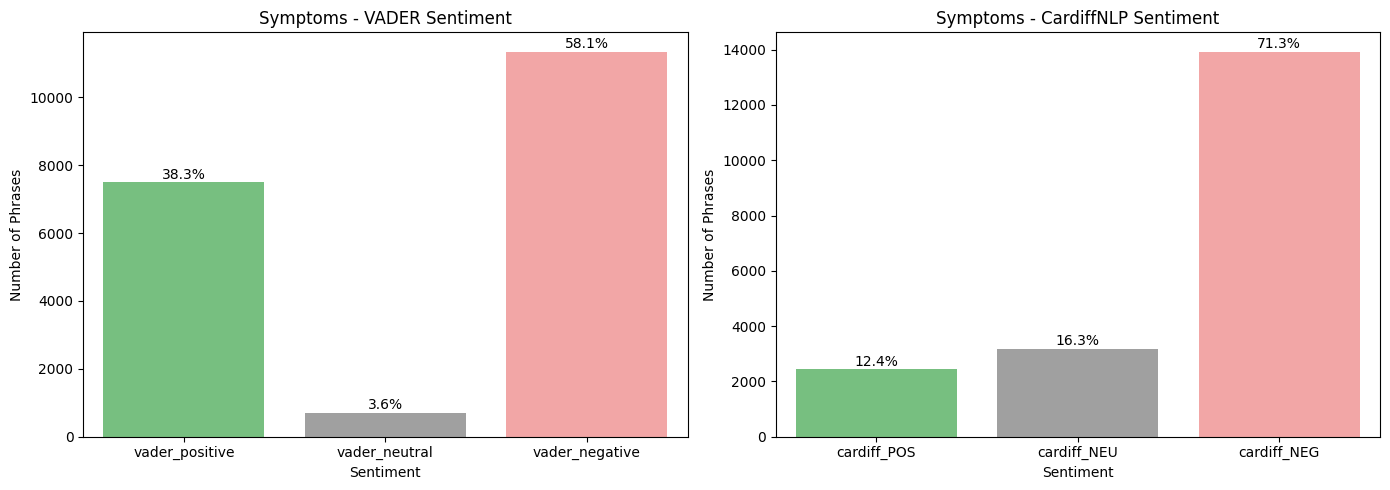

In [ ]:
# ==============================
# 0️⃣ Imports & color palettes
# ==============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Color palettes
vader_colors = {"positive": "#6BCB77", "neutral": "#A0A0A0", "negative": "#FF9999"}
cardiff_colors = {"POS": "#6BCB77", "NEU": "#A0A0A0", "NEG": "#FF9999"}

# ==============================
# 1️⃣ Phrase-Level Aggregation (counts & percentages)
# ==============================
def aggregate_phrase_sentiments(df):
    """
    Compute counts and percentages of VADER & CardiffNLP for each symptom phrase.
    """
    agg_df = df.groupby("comment_body_clean").agg(
        n_comments=("comment_id", "nunique"),
        vader_positive=("vader_label", lambda x: (x=="positive").sum()),
        vader_neutral=("vader_label", lambda x: (x=="neutral").sum()),
        vader_negative=("vader_label", lambda x: (x=="negative").sum()),
        cardiff_POS=("cardiff_label", lambda x: (x=="POS").sum()),
        cardiff_NEU=("cardiff_label", lambda x: (x=="NEU").sum()),
        cardiff_NEG=("cardiff_label", lambda x: (x=="NEG").sum())
    ).reset_index()

    # Add percentages
    for col in ['vader_positive','vader_neutral','vader_negative']:
        agg_df[f"{col}_pct"] = (agg_df[col] / agg_df['n_comments'] * 100).round(2)

    for col in ['cardiff_POS','cardiff_NEU','cardiff_NEG']:
        agg_df[f"{col}_pct"] = (agg_df[col] / agg_df['n_comments'] * 100).round(2)

    return agg_df

# Apply  to symptom phrases
phrase_sentiment_symptoms = aggregate_phrase_sentiments(symptom_phrases_exploded_df)

# Quick preview
phrase_sentiment_symptoms.head()

# ==============================
# 2️⃣ Plot sentiment distribution
# ==============================
def plot_phrase_sentiment_distribution(df, dataset_name="Symptoms"):
    """
    Plots VADER + Cardiff sentiment distributions at phrase level.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    # ---- VADER ----
    counts = df[['vader_positive','vader_neutral','vader_negative']].sum()
    pct = (counts / counts.sum() * 100).round(1)
    sns.barplot(
        x=counts.index, y=counts.values,
        ax=axes[0], palette=[vader_colors['positive'],vader_colors['neutral'],vader_colors['negative']]
    )
    axes[0].set_title(f"{dataset_name} - VADER Sentiment")
    axes[0].set_ylabel("Number of Phrases")
    axes[0].set_xlabel("Sentiment")
    for i, val in enumerate(counts.values):
        axes[0].text(i, val + counts.max()*0.01, f"{pct[i]:.1f}%", ha='center')

    # ---- Cardiff ----
    counts = df[['cardiff_POS','cardiff_NEU','cardiff_NEG']].sum()
    pct = (counts / counts.sum() * 100).round(1)
    sns.barplot(
        x=counts.index, y=counts.values,
        ax=axes[1], palette=[cardiff_colors['POS'],cardiff_colors['NEU'],cardiff_colors['NEG']]
    )
    axes[1].set_title(f"{dataset_name} - CardiffNLP Sentiment")
    axes[1].set_ylabel("Number of Phrases")
    axes[1].set_xlabel("Sentiment")
    for i, val in enumerate(counts.values):
        axes[1].text(i, val + counts.max()*0.01, f"{pct[i]:.1f}%", ha='center')

    plt.tight_layout()
    plt.show()

# Plot for symptom phrases
plot_phrase_sentiment_distribution(phrase_sentiment_symptoms)


In [ ]:
# ==============================
# Phrase-level sentiment tables (VADER + Cardiff)
# ==============================
def print_phrase_sentiment_tables(df):
    # ---- VADER ----
    if 'vader_label' in df.columns:
        vader_counts = df['vader_label'].value_counts()
        vader_pct = (vader_counts / vader_counts.sum() * 100).round(1)
        vader_table = pd.DataFrame({'Count': vader_counts, 'Percentage (%)': vader_pct})
        print("\n===== VADER - Symptoms =====")
        display(vader_table)

    # ---- Cardiff ----
    cardiff_col = 'cardiff_label' if 'cardiff_label' in df.columns else 'cardiff_sentiment'
    if cardiff_col in df.columns:
        cardiff_counts = df[cardiff_col].value_counts()
        cardiff_pct = (cardiff_counts / cardiff_counts.sum() * 100).round(1)
        cardiff_table = pd.DataFrame({'Count': cardiff_counts, 'Percentage (%)': cardiff_pct})
        print("\n===== CardiffNLP - Symptoms =====")
        display(cardiff_table)


# Apply to your symptom phrases dataframe
print_phrase_sentiment_tables(symptom_phrases_exploded_df)



===== VADER - Symptoms =====


,Count,Percentage (%)
vader_label,,
negative,11348,58.1
positive,7490,38.3
neutral,701,3.6



===== CardiffNLP - Symptoms =====


,Count,Percentage (%)
cardiff_label,,
NEG,13933,71.3
NEU,3176,16.3
POS,2430,12.4


break

## 4.5 Heatmaps- cross comparison

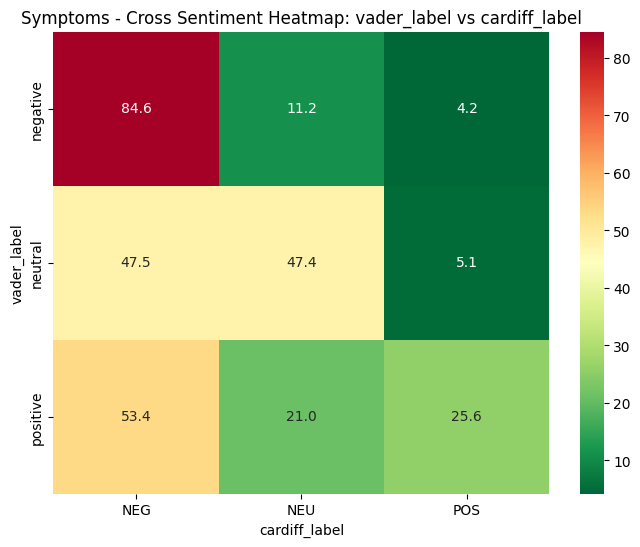

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cross_heatmap(df, col1, col2, dataset_name="Dataset"):
    """
    Plots a cross-tab heatmap of two categorical columns (e.g., VADER vs Cardiff sentiment)
    """
    # Create cross-tab table
    ctab = pd.crosstab(df[col1], df[col2])

    # Add percentages
    ctab_pct = ctab.div(ctab.sum(axis=1), axis=0) * 100

    # Plot heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(ctab_pct, annot=True, fmt=".1f", cmap="RdYlGn_r")
    plt.title(f"{dataset_name} - Cross Sentiment Heatmap: {col1} vs {col2}")
    plt.ylabel(col1)
    plt.xlabel(col2)
    plt.show()

# Apply symptom phrases
plot_cross_heatmap(symptom_phrases_exploded_df, "vader_label", "cardiff_label", "Symptoms")


